# Bayesian neural networks for regression

In this notebook we use the probabilistic modeling library __[Edward](http://edwardlib.org/)__ for a regression task. We train a neural network with both Bayesian and standard (deterministic) methods, and compare the results. We use the __[Concrete Compressive Strength data set](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength)__ from the UCI Machine Learning Repository.

Author: Mikko Kemppainen, Data Scientist, __[Qvik](https://qvik.com)__

In [1]:
import numpy as np
import pandas as pd
from time import time
from matplotlib import pyplot as plt
%matplotlib inline

We begin by loading the dataset.

In [2]:
dataset = pd.read_csv('concrete.csv', header=0, index_col=None, sep=',')
dataset.head(20)

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,47.03
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,43.70
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,36.45
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
Cement (component 1)(kg in a m^3 mixture)                1030 non-null float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    1030 non-null float64
Fly Ash (component 3)(kg in a m^3 mixture)               1030 non-null float64
Water  (component 4)(kg in a m^3 mixture)                1030 non-null float64
Superplasticizer (component 5)(kg in a m^3 mixture)      1030 non-null float64
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     1030 non-null float64
Fine Aggregate (component 7)(kg in a m^3 mixture)        1030 non-null float64
Age (day)                                                1030 non-null int64
Concrete compressive strength(MPa, megapascals)          1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


We divide the dataset into training and testing sets. The training set is frequently referred to by $\mathcal{D}$ and data points from either set are denoted by $\mathbf{x}$. 

In [4]:
data = dataset.iloc[:, [0,1,2,3,4,5,6,7]].values
target = dataset.iloc[:, 8].values

perm = np.random.permutation(len(dataset))
data = data[perm]
target = target[perm]

n_train = 900
data_train = data[:n_train]
target_train = target[:n_train]
data_test = data[n_train:]
target_test = target[n_train:]

results = pd.DataFrame()
results['target'] = target_test

## Linear model

Before moving forward with neural networks, let us fit a standard ridge regression linear model.

In [5]:
from sklearn import linear_model

linregr = linear_model.RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1.0])
linregr.fit(data_train, target_train)

results['linear_model'] = linregr.predict(data_test)

## Neural network model

We define a neural network with two hidden layers of dimensions $H_0$ and $H_1$. With $D$-dimensional input, the parameters are
$$
\mathbf{W}_0 \in \mathbb{R}^{D\times H_0}, \mathbf{W}_1 \in \mathbb{R}^{H_0\times H_1}, \mathbf{W}_2 \in \mathbb{R}^{H_1\times 1}, \mathbf{b}_0 \in \mathbb{R}^{H_0}, \mathbf{b}_1 \in \mathbb{R}^{H_1}, b_2 \in \mathbb{R},
$$
and the neural network with rectified linear unit activations is defined as
$$
\text{NN}: \mathbb{R}^D \to \mathbb{R}^{H_0} \to \mathbb{R}^{H_1} \to \mathbb{R} ; \quad
\mathbf{x} \mapsto \mathbf{h}_1 = \max(0, \mathbf{W}_0^\top \mathbf{x} + \mathbf{b}_0)
\mapsto \mathbf{h}_2 = \max(0, \mathbf{W}_1^\top \mathbf{h}_1 + \mathbf{b}_1)
\mapsto \mathbf{W}_2^\top \mathbf{h}_2 + b_2.
$$


In [6]:
D = data.shape[1]
H0 = 5
H1 = 5

import tensorflow as tf

def neural_network(X,W_0,W_1,W_2,b_0,b_1,b_2):
    hidden1 = tf.nn.relu(tf.matmul(X,W_0) + b_0)
    hidden2 = tf.nn.relu(tf.matmul(hidden1,W_1) + b_1)
    output = tf.matmul(hidden2,W_2) + b_2
    return tf.reshape(output, [-1])

## Deterministic neural network

Let us train the neural network by minimizing the mean squared error loss function, as usual.

In [7]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data_train)

data_train_scaled = scaler.transform(data_train)
data_test_scaled = scaler.transform(data_test)

W_0 = tf.Variable(tf.ones([D, H0]))
W_1 = tf.Variable(tf.ones([H0, H1]))
W_2 = tf.Variable(tf.ones([H1, 1]))
b_0 = tf.Variable(tf.ones(H0))
b_1 = tf.Variable(tf.ones(H1))
b_2 = tf.Variable(tf.ones(1))
    
X = tf.placeholder(tf.float32, shape=[None, D])
y = neural_network(X,W_0,W_1,W_2,b_0,b_1,b_2)
    
y_true = tf.placeholder(tf.float32, shape=[None,])

mse = tf.losses.mean_squared_error(y_true, y)

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.1
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           10000, 0.3, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(mse, global_step=global_step)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    batch_size = 10
    n_batch = np.int(n_train / batch_size)
    loss_values1k = []
    loss_values10k = []
    for j in range(100000):
        if j % 10000 == 0:
            print('Learning rate: {0:.6f}'.format(optimizer._lr.eval()))
        i = j % n_batch
        df_data = data_train_scaled[i*batch_size:(i+1)*batch_size]
        df_target = target_train[i*batch_size:(i+1)*batch_size]
        idx = np.random.choice(batch_size, batch_size - 1, replace=False)
        df_data = df_data[idx, :]
        df_target = df_target[idx]
        _, loss_value = sess.run([train_step, mse], {X: df_data, y_true: df_target})
        loss_values1k.append(loss_value)
        loss_values10k.append(loss_value)
        if j % 1000 == 999:
            print('Step {}: loss = {}'.format(j+1, np.round(np.float(np.mean(loss_values1k)), 2)))
            loss_values1k = []
        if j % 10000 == 9999:
            print('Average loss = {}'.format(np.round(np.float(np.mean(loss_values10k)), 2))) 
            loss_values10k = []
    
    results['det_prediction'] = neural_network(tf.constant(data_test_scaled, dtype=tf.float32, shape=[len(data_test),D]), W_0,W_1,W_2,b_0,b_1,b_2).eval()
    Wd_0, Wd_1, Wd_2, bd_0, bd_1, bd_2 = W_0.eval(), W_1.eval(), W_2.eval(), b_0.eval(), b_1.eval(), b_2.eval()

Learning rate: 0.100000
Step 1000: loss = 133.7
Step 2000: loss = 127.42
Step 3000: loss = 126.95
Step 4000: loss = 128.3
Step 5000: loss = 126.36
Step 6000: loss = 125.42
Step 7000: loss = 128.56
Step 8000: loss = 128.49
Step 9000: loss = 127.86
Step 10000: loss = 126.93
Average loss = 128.0
Learning rate: 0.030000
Step 11000: loss = 117.02
Step 12000: loss = 114.46
Step 13000: loss = 114.37
Step 14000: loss = 112.26
Step 15000: loss = 111.82
Step 16000: loss = 110.04
Step 17000: loss = 111.12
Step 18000: loss = 111.46
Step 19000: loss = 110.67
Step 20000: loss = 111.85
Average loss = 112.51
Learning rate: 0.009000
Step 21000: loss = 108.3
Step 22000: loss = 108.21
Step 23000: loss = 108.99
Step 24000: loss = 107.89
Step 25000: loss = 108.59
Step 26000: loss = 108.39
Step 27000: loss = 108.73
Step 28000: loss = 109.43
Step 29000: loss = 107.85
Step 30000: loss = 107.45
Average loss = 108.38
Learning rate: 0.002700
Step 31000: loss = 106.9
Step 32000: loss = 107.15
Step 33000: loss = 1

## Bayesian training of the neural network

Let us denote the parameters of the neural network by $\theta = \{ \mathbf{W}_0, \mathbf{W}_1, \mathbf{W}_2, \mathbf{b}_0, \mathbf{b}_1, b_2 \}$, and define the prior $p(\theta)$ by setting each component of each parameter to have a standard normal distribution. We then define the likelihood as a normal distribution with fixed variance $\sigma_y^2$:
$$
p( \, y \ | \, \mathbf{x}, \theta \, ) = \mathcal{N}( \, y \, | \, \text{NN}(\mathbf{x}; \theta), \sigma_y^2 \, ).
$$
In addition, we scale the data to be centered and have unit variance.

In [8]:
import edward as ed

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data_train)

data_train_scaled = scaler.transform(data_train)
data_test_scaled = scaler.transform(data_test)

sigma_y = 1.0

from edward.models import Normal, NormalWithSoftplusScale

W_0 = Normal(loc=tf.zeros([D, H0]), scale=5.0 * tf.ones([D, H0]))
W_1 = Normal(loc=tf.zeros([H0, H1]), scale=5.0 * tf.ones([H0, H1]))
W_2 = Normal(loc=tf.zeros([H1, 1]), scale=5.0 * tf.ones([H1, 1]))
b_0 = Normal(loc=tf.zeros(H0), scale=5.0 * tf.ones(H0))
b_1 = Normal(loc=tf.zeros(H1), scale=5.0 * tf.ones(H1))
b_2 = Normal(loc=tf.zeros(1), scale=5.0 * tf.ones(1))

X = tf.placeholder(tf.float32, [None, D])
y = Normal(loc=neural_network(X,W_0,W_1,W_2,b_0,b_1,b_2), scale=sigma_y)

Since exact inference of the posterior is intractable, we resort to methods from variational inference.
This amounts to approximating the posterior $p( \, \theta \, | \, \mathcal{D} \, )$ by a parametrized family $q( \, \theta \, ; \, \lambda \, )$, which we choose to consist of normal variables of unknown mean and variance (represented here by $\lambda$).

In [9]:
qW_0 = NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([D, H0])), 
                               scale=tf.Variable(tf.random_normal([D, H0])))
qW_1 = NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([H0, H1])),
                               scale=tf.Variable(tf.random_normal([H0, H1])))
qW_2 = NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([H1, 1])), 
                               scale=tf.Variable(tf.random_normal([H1, 1])))
qb_0 = NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([H0])), 
                               scale=tf.Variable(tf.random_normal([H0])))
qb_1 = NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([H1])),
                               scale=tf.Variable(tf.random_normal([H1])))
qb_2 = NormalWithSoftplusScale(loc=tf.Variable(tf.random_normal([1])),
                               scale=tf.Variable(tf.random_normal([1])))

We choose $\lambda^*$ by minimizing the Kullback-Leibler divergence (from $q$ to $p$):
$$
\lambda^* = \text{argmin}_\lambda \, \mathbb{E}_{q(\theta ; \lambda)} \big( \, \log \, q (\, \theta \, ; \, \lambda \, ) - \log \, p( \, \theta \, | \, \mathcal{D} \, ) \, \big) .
$$

In [10]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1,
                     W_2: qW_2, b_2: qb_2}, data={X: data_train_scaled, y: target_train})

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.05
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           10000, 0.3, staircase=True)

optimizer = tf.train.AdamOptimizer(learning_rate)

inference.run(n_iter=20000, optimizer=optimizer, global_step=global_step)

20000/20000 [100%] ██████████████████████████████ Elapsed: 76s | Loss: 14306.295


In general, the posterior predictive distribution for a new data point $\mathbf{x}$ is given by
$$
p( \, y \, | \, \mathbf{x}, \mathcal{D} \, ) = \int p( \, y \, | \, \mathbf{x}, \theta \, ) \, p( \, \theta \, | \, \mathcal{D} \, ) \, d\theta .
$$
We use Monte Carlo approximation to calculate the integral:
\begin{align*}
p( \, y \, | \, \mathbf{x}, \mathcal{D} \, ) &= \int \mathcal{N}( \, y \, | \, \text{NN}(\mathbf{x}; \theta), \sigma_y^2 \, ) \, p( \, \theta \, | \, \mathcal{D} \, ) \, d\theta \\
&\sim \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} \mathcal{N}( \, y \, | \, \text{NN}(\mathbf{x}; \theta_i), \sigma_y^2 \, ) .
\end{align*}
First we need to sample from the posterior, or rather, from the approximating distribution $q( \, \theta \, ; \, \lambda^* \, )$, which gives us 
$$
\text{NN}(\mathbf{x}, \theta_i), \quad i=0,1,\ldots , n_\text{samples},
$$
for each new data point $\mathbf{x}\in\mathbb{R}^D.$

In [11]:
n_samples = 1000

qW_0_samples = qW_0.sample(sample_shape=n_samples)
qW_1_samples = qW_1.sample(sample_shape=n_samples)
qW_2_samples = qW_2.sample(sample_shape=n_samples)
qb_0_samples = qb_0.sample(sample_shape=n_samples)
qb_1_samples = qb_1.sample(sample_shape=n_samples)
qb_2_samples = qb_2.sample(sample_shape=n_samples)

print("Preparing to sample...")
t0 = time()
samplenodes = tf.stack([neural_network(X,qW_0_samples[i],qW_1_samples[i],qW_2_samples[i],
                                       qb_0_samples[i],qb_1_samples[i],qb_2_samples[i]) 
                        for i in range(n_samples)], axis=0)
print("Took", np.int(time() - t0), "secs.")

print("Sampling...")
t0 = time()
samplepredictions = samplenodes.eval(feed_dict={X: data_test_scaled})
print("Took", np.int(time() - t0), "secs.")

Preparing to sample...
Took 41 secs.
Sampling...
Took 20 secs.


Forming the posterior predictive distribution as a mixture distribution using all the sample predictions directly is computationally too heavy. We therefore group the sample predictions into histograms and form the mixture according to those.

In [12]:
probs = []
centers = []

for i in range(len(data_test_scaled)):
    histogram = np.histogram(samplepredictions[:,i], bins=20)
    probs.append(histogram[0] / n_samples)
    delta = histogram[1][1] - histogram[1][0]
    centers.append([np.float32(a + delta / 2) for a in histogram[1][:-1]])

In [13]:
from edward.models import Categorical, Mixture
y_post = []

t0 = time()
for i in range(len(data_test_scaled)):
    print("Forming the posterior predictive distribution for test data point", i+1, "/", len(data_test_scaled), "...")
    y_post.append(Mixture(Categorical(probs = probs[i]), 
                  [Normal(loc=centers[i][j], scale=sigma_y) for j in range(len(centers[i]))]))
    
print("Took altogether", np.int(time() - t0), "secs.")

Forming the posterior predictive distribution for test data point 1 / 130 ...
Forming the posterior predictive distribution for test data point 2 / 130 ...
Forming the posterior predictive distribution for test data point 3 / 130 ...
Forming the posterior predictive distribution for test data point 4 / 130 ...
Forming the posterior predictive distribution for test data point 5 / 130 ...
Forming the posterior predictive distribution for test data point 6 / 130 ...
Forming the posterior predictive distribution for test data point 7 / 130 ...
Forming the posterior predictive distribution for test data point 8 / 130 ...
Forming the posterior predictive distribution for test data point 9 / 130 ...
Forming the posterior predictive distribution for test data point 10 / 130 ...
Forming the posterior predictive distribution for test data point 11 / 130 ...
Forming the posterior predictive distribution for test data point 12 / 130 ...
Forming the posterior predictive distribution for test data p

Forming the posterior predictive distribution for test data point 105 / 130 ...
Forming the posterior predictive distribution for test data point 106 / 130 ...
Forming the posterior predictive distribution for test data point 107 / 130 ...
Forming the posterior predictive distribution for test data point 108 / 130 ...
Forming the posterior predictive distribution for test data point 109 / 130 ...
Forming the posterior predictive distribution for test data point 110 / 130 ...
Forming the posterior predictive distribution for test data point 111 / 130 ...
Forming the posterior predictive distribution for test data point 112 / 130 ...
Forming the posterior predictive distribution for test data point 113 / 130 ...
Forming the posterior predictive distribution for test data point 114 / 130 ...
Forming the posterior predictive distribution for test data point 115 / 130 ...
Forming the posterior predictive distribution for test data point 116 / 130 ...
Forming the posterior predictive distrib

In order to derive some statistics, we sample from the posterior predictive distribution.

In [14]:
t0 = time()
print("Sampling the posterior predictive distribution for", len(data_test_scaled), "test data points...")
posteriorsamplenodes = tf.stack([y_post[i].sample(n_samples) for i in range(len(data_test_scaled))], axis=1)
posteriorsamples = pd.DataFrame(posteriorsamplenodes.eval())
print("Took", np.int(time() - t0), "secs.")

Sampling the posterior predictive distribution for 130 test data points...
Took 220 secs.


Our prediction is the mean of posterior predictive samples. We also include higher and lower quantiles to describe the width of the distribution. 

In [15]:
predictions = posteriorsamples.mean()
predictions_low = posteriorsamples.quantile(0.01)
predictions_high = posteriorsamples.quantile(0.99)

In [16]:
results['ed_prediction'] = predictions
results['ed_prediction_low'] = predictions_low
results['ed_prediction_high'] = predictions_high

## Comparison of results

In [17]:
results = results.applymap(lambda x: np.round(x,2))
results

,target,linear_model,det_prediction,ed_prediction,ed_prediction_low,ed_prediction_high
0,55.55,51.63,50.63,50.23,47.95,52.79
1,41.54,33.87,32.85,41.68,39.44,44.07
2,14.14,34.91,33.12,23.35,21.03,25.80
3,39.30,30.58,28.36,36.02,33.69,38.34
4,26.31,27.64,28.35,24.12,21.95,26.47
5,47.82,38.55,40.50,47.78,45.38,49.95
6,59.00,46.54,46.50,54.58,52.07,57.08
7,19.20,28.51,27.84,20.19,17.57,22.71
8,21.91,33.41,32.80,19.81,17.61,22.05
9,30.22,32.25,33.05,39.06,36.79,41.47


In [18]:
from sklearn.metrics import mean_squared_error

print("MSE on test data for linear model:")
print(np.round(mean_squared_error(results['linear_model'], results['target']), 2))

print("MSE on test data for deterministic neural network:")
print(np.round(mean_squared_error(results['det_prediction'], results['target']), 2))

print("MSE on test data for Bayesian neural network:")
print(np.round(mean_squared_error(results['ed_prediction'], results['target']), 2))

MSE on test data for linear model:
95.28
MSE on test data for deterministic neural network:
93.12
MSE on test data for Bayesian neural network:
28.08


## Inspecting the models

Let's take a look at the weights and see if they've been optimized to similar values.

In [19]:
print('W_0 from deterministic training:')
print(Wd_0)
print('W_0 from Bayesian training:')
print(qW_0.loc.eval())

W_0 from deterministic training:
[[ 2.66601682  2.66601682  2.66601682  2.66601682  2.92571712]
 [ 1.73840678  1.73840678  1.73840678  1.73840678  2.9166522 ]
 [ 0.60036492  0.60036492  0.60036492  0.60036492  3.68976974]
 [ 0.29605603  0.29605603  0.29605603  0.29605603 -4.59670067]
 [ 0.67785931  0.67785931  0.67785931  0.67785931 -1.47428668]
 [-0.20046806 -0.20046806 -0.20046806 -0.20046806  2.58389068]
 [ 0.30114871  0.30114871  0.30114871  0.30114871  0.98309416]
 [ 1.44312334  1.44312334  1.44312334  1.44312334  1.71007252]]
W_0 from Bayesian training:
[[ 3.14547992  4.71783972  6.24905539  2.29415345  3.84848571]
 [ 1.84507084  2.98887062  4.68613005  1.2512002   2.39415646]
 [ 0.96550888  2.93084455  3.94450307  1.52219033  0.77586323]
 [ 0.20543382  3.18961048  0.93529797  1.17745507 -1.23368979]
 [ 0.09277299  3.35541773  1.68360233  0.67555594 -2.43366885]
 [ 0.63920099  3.30827165  4.43088007  1.71288705  1.36214495]
 [ 0.90005815  3.88232064  4.24174976  1.67589736  1.261

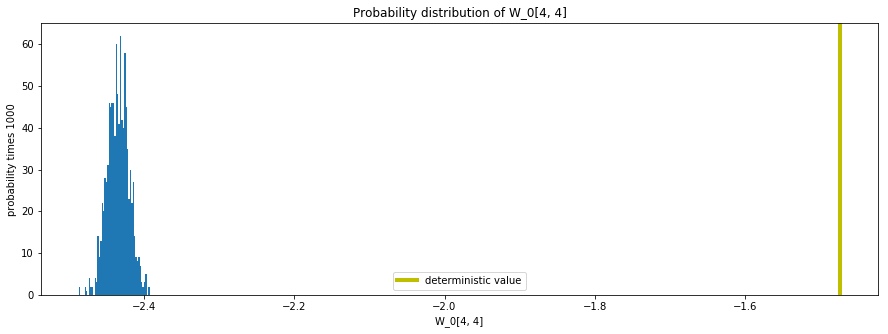

In [20]:
i = np.random.randint(D)
j = np.random.randint(H0)

plt.figure(figsize=(15,5))

_, _, histogram = plt.hist(qW_0_samples.eval()[:,i,j], bins=50)
plt.xlabel("W_0[{0}, {1}]".format(i,j))
plt.ylabel("probability times " + str(n_samples))
plt.axvline(Wd_0[i,j], color='y', linewidth=4, label="deterministic value")
plt.legend()
plt.title("Probability distribution of W_0[{0}, {1}]".format(i,j))

In [21]:
print('W_1 from deterministic training:')
print(Wd_1)
print('W_1 from Bayesian training:')
print(qW_1.loc.eval())

W_1 from deterministic training:
[[  4.74196583e-01   4.74196583e-01   4.74196583e-01   4.74196583e-01
   -3.61112616e-05]
 [  4.74196583e-01   4.74196583e-01   4.74196583e-01   4.74196583e-01
   -3.61112616e-05]
 [  4.74196583e-01   4.74196583e-01   4.74196583e-01   4.74196583e-01
   -3.61112616e-05]
 [  4.74196583e-01   4.74196583e-01   4.74196583e-01   4.74196583e-01
   -3.61112616e-05]
 [  6.62715614e-01   6.62715614e-01   6.62715614e-01   6.62715614e-01
   -1.59197996e-04]]
W_1 from Bayesian training:
[[-5.12049675  2.5779717  -5.45081758  3.56290507  2.27195573]
 [-2.16884756 -3.83262515 -1.72466624  1.3118422  -3.61792302]
 [-2.90381074  2.47801924 -3.61431599 -3.72595835  3.62005734]
 [-2.32894325 -3.30135345 -0.85581762  0.24382181 -3.97889829]
 [-2.03876305 -2.72347212 -3.24826598 -0.69157583 -1.95854187]]


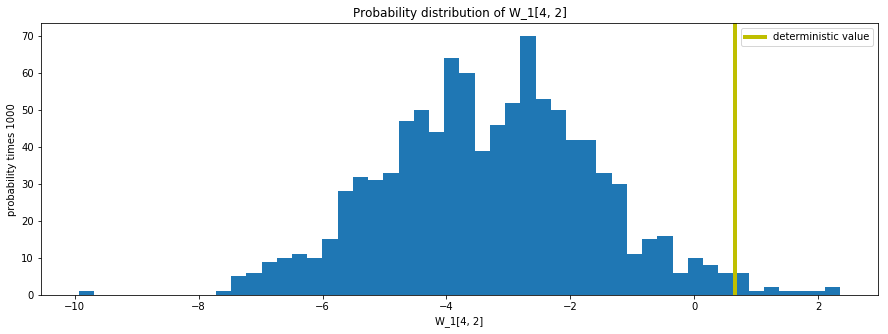

In [22]:
i = np.random.randint(H0)
j = np.random.randint(H1)

plt.figure(figsize=(15,5))

_, _, histogram = plt.hist(qW_1_samples.eval()[:,i,j], bins=50)
plt.xlabel("W_1[{0}, {1}]".format(i,j))
plt.ylabel("probability times " + str(n_samples))
plt.axvline(Wd_1[i,j], color='y', linewidth=4, label="deterministic value")
plt.legend()
plt.title("Probability distribution of W_1[{0}, {1}]".format(i,j))

In [23]:
print('W_2 from deterministic training:')
print(Wd_2)
print('W_2 from Bayesian training:')
print(qW_2.loc.eval())

W_2 from deterministic training:
[[  4.91783082e-01]
 [  4.91783082e-01]
 [  4.91783082e-01]
 [  4.91783082e-01]
 [ -4.99852104e-06]]
W_2 from Bayesian training:
[[-0.4551757 ]
 [-1.51572108]
 [-0.62930226]
 [ 1.08082926]
 [ 3.08351088]]


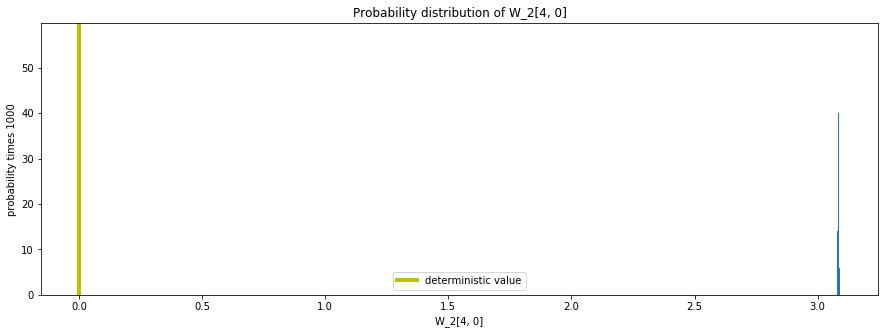

In [24]:
i = np.random.randint(H1)
j = 0

plt.figure(figsize=(15,5))

_, _, histogram = plt.hist(qW_2_samples.eval()[:,i,j], bins=50)
plt.xlabel("W_2[{0}, {1}]".format(i,j))
plt.ylabel("probability times " + str(n_samples))
plt.axvline(Wd_2[i,j], color='y', linewidth=4, label="deterministic value")
plt.legend()
plt.title("Probability distribution of W_2[{0}, {1}]".format(i,j))

It looks like the weights have been optimized to very different values.

## Inspecting the predictions

Predictions for a random test data point are as follows:

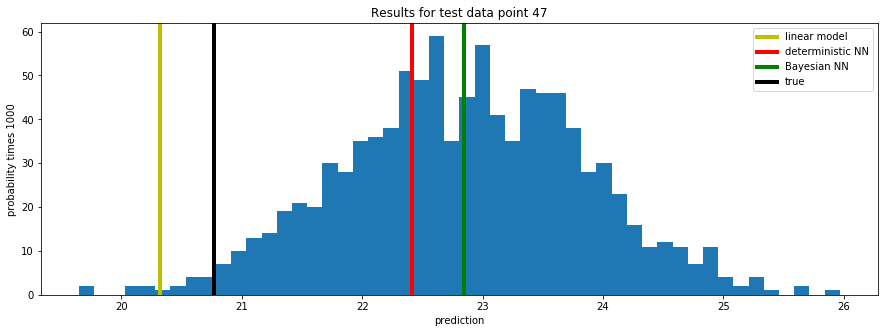

In [25]:
test_sample_number = np.random.choice(range(len(data_test_scaled)))

plt.figure(figsize=(15,5))

_, _, histogram = plt.hist(posteriorsamples[test_sample_number].values, bins=50)
plt.xlabel("prediction")
plt.ylabel("probability times " + str(n_samples))
plt.axvline(results.loc[test_sample_number, 'linear_model'], color='y', linewidth=4, label="linear model")
plt.axvline(results.loc[test_sample_number, 'det_prediction'], color='r', linewidth=4, label="deterministic NN")
plt.axvline(results.loc[test_sample_number, 'ed_prediction'], color='g', linewidth=4, label="Bayesian NN")
plt.axvline(results.loc[test_sample_number, 'target'], color='k', linewidth=4, label="true")
plt.legend()
plt.title("Results for test data point " + str(test_sample_number))

As both the likelihood and the approximations for weight probabilities were given by normal distributions, it is not at all surprising that also the posterior predictive distributions are very close to normal. This is depicted in the Q-Q plot below: 

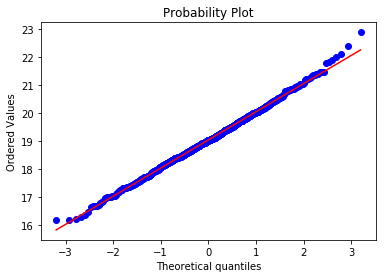

In [26]:
test_sample_number = np.random.choice(range(len(data_test_scaled)))

import pylab 
import scipy.stats as stats

_, fig = stats.probplot(posteriorsamples[test_sample_number].values, dist="norm", plot=pylab)

Moreover, standard deviations of all the predictions are very close to each other and roughly equal to the standard deviation of the likelihood. 

In [27]:
print("Standard deviation of posterior predictive distribution for test data point {}: ".format(test_sample_number)
      + str(np.round(posteriorsamples.std()[test_sample_number],2)))
print("Average standard deviation of posterior predictive distributions: " 
      + str(np.round(posteriorsamples.std().mean(),2)))
print("Standard deviation of the likelihood:", sigma_y)

Standard deviation of posterior predictive distribution for test data point 108: 1.0
Average standard deviation of posterior predictive distributions: 1.03
Standard deviation of the likelihood: 1.0


## Final remarks

The neural network appeared to perform better with Bayesian training, which optimized the weights completely differently compared to the deterministic training. **Can we improve the performance of the deterministic network by changing its size and adjusting its training?**

From a Bayesian point of view our variational approximation of the posterior is quite unsatisfactory. Our inference fails to capture dependence between weights on different layers. Perhaps this could be remedied by using the `Empirical` distribution class and, for instance, Hamiltonian Monte Carlo inference. Moreover, it would be desirable to infer also the likelihood variance, which we've now fixed in our model.